# Chapter 21

# How certain is the model; parametric bootstrapping

**Student:** Luciano Carvalho

## Introduction  

Previously, we have investigated the nonparametric bootstrap resampling method. We used bootstrap resampling to compute a point estimate and confidence interval for simple univariate statistics.

The bootstrap method can also be applied to regression models. Computing the bootstrap distribution of the regression model parameters provides insight into variability of these parameters. It is useful to know how much random variation there is in regression coefficients simply because of a small change in training data values.   

To proceed, we need to define our terminology:  

- **Parametric bootstrap:** Linear regression is an example of a **parametric model**. Simply, a parametric model is a model with parameters which must be estimated. A parametric bootstrap process is used to find point estimates of the model parameters and the associated uncertainty or confidence intervals. For each bootstrap resample created, a new estimate of the model parameters is computed. For example, a regression model estimates parameters that minimize the sum of squared errors. In the previous chapter, we showed that this least squares model assumes a Normal likelihood model for the residuals, making application of a bootstrap algorithm parametric.      
- **Nonparametric bootstrap:** Some statistical estimates have no particular model associated with them. Examples include the mean, variance and bootstrap confidence intervals. These values can be estimated using the bootstrap method without specifying a parametric model. The nonparametric bootstrap makes no assumptions about a likelihood model, and therefore has no parameters.  

Which bootstrap model should you use? The answer is not straight forward. You must consider the following:
1. Generally, the parametric bootstrap gives tighter confidence intervals, if the model assumptions are reasonably correct.
2. If the model assumptions are violated, the parametric bootstrap will give poor results and a nonparametric bootstrap is preferred.

As with most statistics, it is possible to bootstrap the parameters of most any regression model. However, since bootstrap resampling uses a large number of subsamples, it can be computationally intensive. For large-scale problems it is necessary to use other resampling methods like cross-validation.

## An Example

Let's try an example. We will work with a simple regression model similar to the one used in Chapter 19.

As a first step, execute the code in the cell below to import the required packages and generate a synthetic data set.

In [9]:
import numpy as np
import numpy.random as nr
import pandas as pd
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Paramters of generated data
n_points = 50
x_start, x_end = 0, 10
y_sd = 1

# Generate data columns
nr.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = x_data + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.000000,1.475868
1,0.204082,0.915564
2,0.408163,2.216802
3,0.612245,1.362557
4,0.816327,3.521151


Now, plot these data and examine the result by executing the code in the cell below.  

(0.0, 11.0)

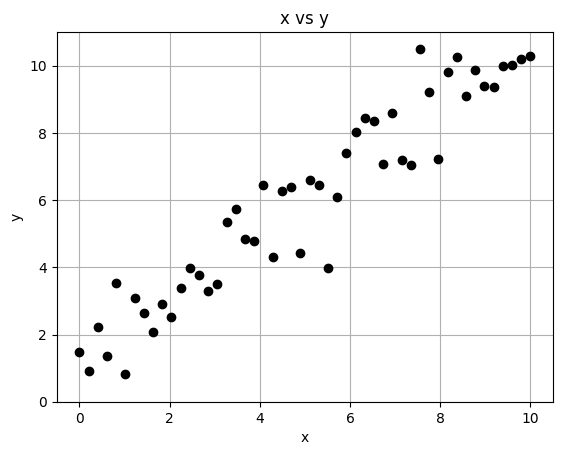

In [10]:
# Matplotlib may give some font errors when loading for the first time, you can ignore these
plt.plot(sim_data['x'], sim_data['y'], 'ko')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.ylim(0,11)

## Parametric Bootstrap of Regression

We will now apply the parametric bootstrap algorithm to a simple parametric model, a regression model. The work is done in a `for loop`, run once for each bootstrap sample with the following steps:   
1. Bernoulli sample the rows of the data frame with replacement with same number of rows as the original frame.    
2. Compute the OLS model using the Bernoulli sample.   
3. Save the model parameters in the data frame to be returned.   
Execute the code below and example the result.   

In [11]:
def resample_regression(df, n_boots, n_params=2, formula='y ~ x'):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        ## Compute the OLS model
        boot_model = sm.ols(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

param_boots = resample_regression(sim_data,2000)
param_boots[:5]

array([[1.13290799, 0.98560489],
       [1.34751537, 0.93057827],
       [1.36160617, 0.94383043],
       [1.1759036 , 0.99644286],
       [1.16683758, 0.99379272]])

You can see the first few bootstrap estimates of the intercept and slope coefficients. Notice the resampling leads to considerable variation in these values.       

Let's compute and display the bootstrap distributions of the slope and intercept parameters. Execute the code in the cell below to examine the distribution of the intercept, along with the confidence intervals.

Parameter = intercept
Mean = 1.3008523334554487
Upper confidence interval = 1.7155107197527013
Lower confidence interval = 0.8977496367224304


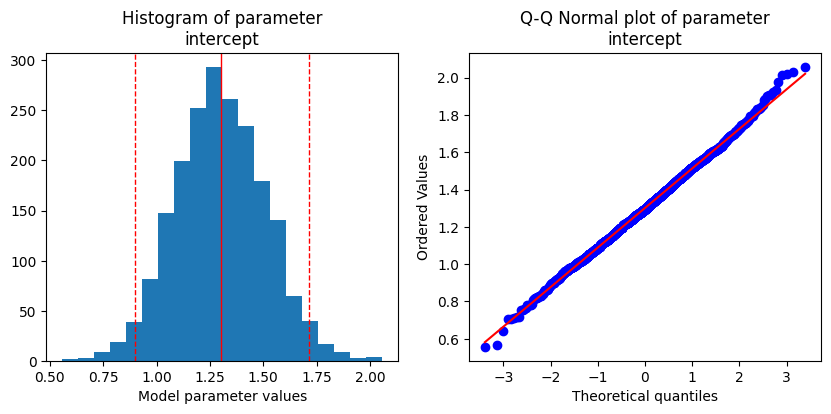

In [12]:
def compute_CI(values, p=0.05):
    mean = np.mean(values)
    p = 100 * p / 2.0
    UCI = np.percentile(values, 100 - p)
    LCI = np.percentile(values, p)
    print(f'Mean = {mean}')
    print(f'Upper confidence interval = {UCI}')
    print(f'Lower confidence interval = {LCI}')
    return(mean, UCI, LCI)

def plot_boot_params(params, parameter='intercept'):
    print(f'Parameter = {parameter}')
    mean, UCI, LCI = compute_CI(params)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    ax[0].hist(params, bins=20)
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')

    ax[0].set_title('Histogram of parameter\n' + parameter)
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of parameter\n' + parameter)
    plt.show()

plot_boot_params(param_boots[:,0])

Next, execute the code in the cell below to display a plot of the slope parameter, along with the confidence intervals.

Parameter = slope
Mean = 0.9419628015641599
Upper confidence interval = 1.0149980300933887
Lower confidence interval = 0.8736302602148219


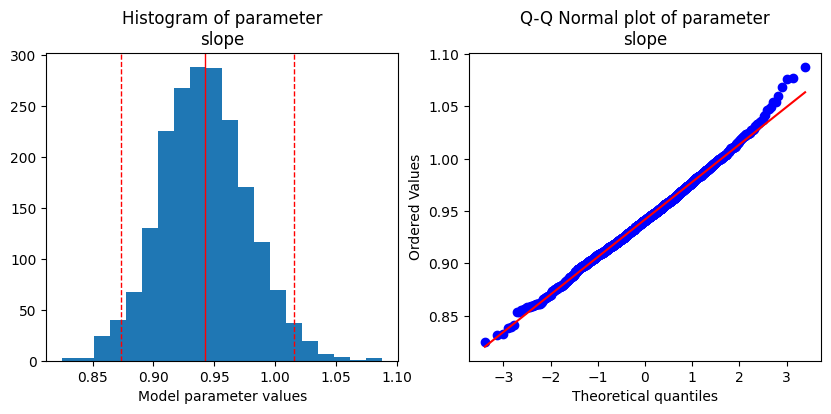

In [13]:
plot_boot_params(param_boots[:,1], parameter='slope')

From the plots above you can see the variability and confidence intervals of the parameter estimates. Consider the answers to the following questions:  
1. Are the bootstrap distribution values approximately Normal?
2. Does one coefficient have greater variability than the other, and if so, which one?  
3. Are the known parameter values of the synthetic data within the confidence intervals?

> **Answers:**

> 1. Yes, the bootstrap distribution values for both the intercept and slope appear to be approximately Normal. This conclusion is supported by the histograms showing bell-shaped distributions and the Q-Q plots, where most of the points fall closely along the red line, indicating that the parameter distributions are roughly Normal

> 2. The intercept parameter seems to have more variability than the slope. The histogram for the intercept shows a wider spread compared to the slope, and the confidence intervals (UCI and LCI) for the intercept are wider than those for the slope. This suggests that the slope parameter is more stable across the bootstrap samples

> 3. Yes, the known parameter values are within the confidence intervals. For the intercept, the synthetic data had a true value of around 1.0, and for the slope, the true value was approximately 1.0. Both of these values fall within the computed confidence intervals from the bootstrap distributions

You can also plot bootstrap realizations of the regression line. This will give you a feel for the variability of the regression solutions. Execute the code in the cell below and examine the result.    

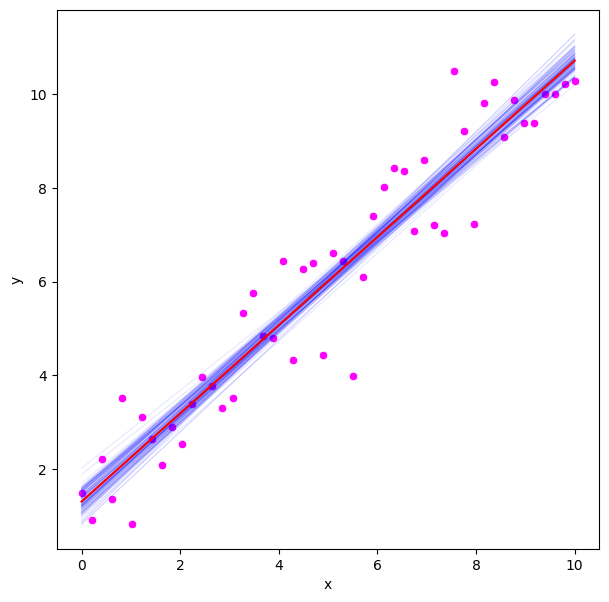

In [14]:
def plot_boot_regression(boot_params, df, plot_x_col='x', plot_y_col='y', cols='x', xlabel='x', ylabel='y', n_lines = 100):
    ## Find the mean slope and intercept and plot the line
    means = np.mean(boot_params, axis=0)
    ## randomly select n_lines to plot
    sample_indx = nr.choice(range(boot_params.shape[0]),n_lines)
    ## Plot the observations
    fig,ax = plt.subplots(figsize=(7,7))
    ax = sns.scatterplot(x=plot_x_col, y=plot_y_col, data=df, color = 'magenta', ax=ax)
    ## Loop over the number of bootstrap regression lines to be displayed
    for indx in sample_indx:
        df['predicted'] = boot_params[indx,0] + np.multiply(df[cols], boot_params[indx,1:])
        sns.lineplot(x=plot_x_col, y='predicted', data=df, color='Blue', size = 1.0, alpha=0.1, ax=ax)
    ## Plot the mean regression line
    df['predicted'] = means[0] + np.multiply(df[cols] ,means[1:])
    sns.lineplot(x=plot_x_col, y='predicted', data=df, color='red', ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()

plot_boot_regression(param_boots, sim_data)

The plot above shows the following:   
1. The heavy line is the mean parameter regression line.   
2. The light blue lines show a selected number of the bootstrap regression lines. Notice the variability in these possible models.

## Another Example      

To further illustrate the foregoing concepts you will now work though another example using the auto price data.  

> **Exercise 21-1:** As a first step you will construct a parametric OLS regression model for the price of automobiles. The code in the cell below loads and prepares the auto price dataset. To compute and display the bootstrap distributions of the model parameters do the following:    
> 1. Use the `resample_regression` function to compute 2000 bootstrap realizations of a regression model using formula `'log_price ~ curb_weight_centered*engine_size_centered'`. This model includes the interaction term between the two independent variables.   
> 2. For each set of model parameters call the `plot_boot_params`. The first argument is the column of your bootstrap parameter Numpy array. The second, `parameter`, argument set to the parameter name in `['intercept', 'curb_weight_centered','engine_size_centered', 'curb_weight_centered:engine_size_centered']`.      

Parameter = intercept
Mean = 9.399842671650685
Upper confidence interval = 9.447871753644831
Lower confidence interval = 9.352361172209509


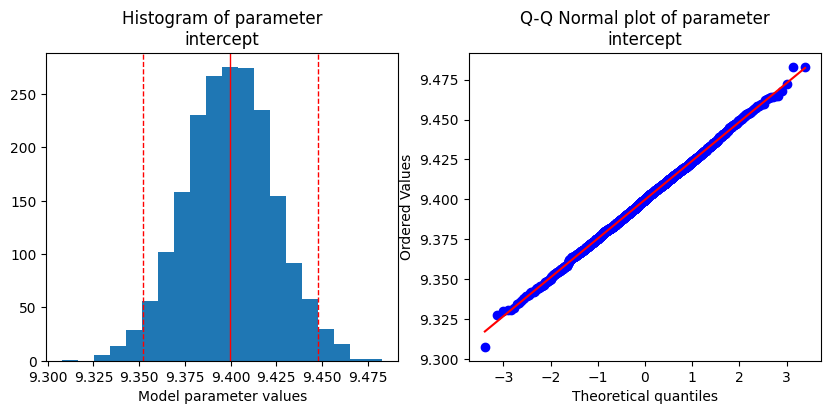

Parameter = curb_weight_centered
Mean = 0.0004921560124281446
Upper confidence interval = 0.000661663459755777
Lower confidence interval = 0.0003433181842696155


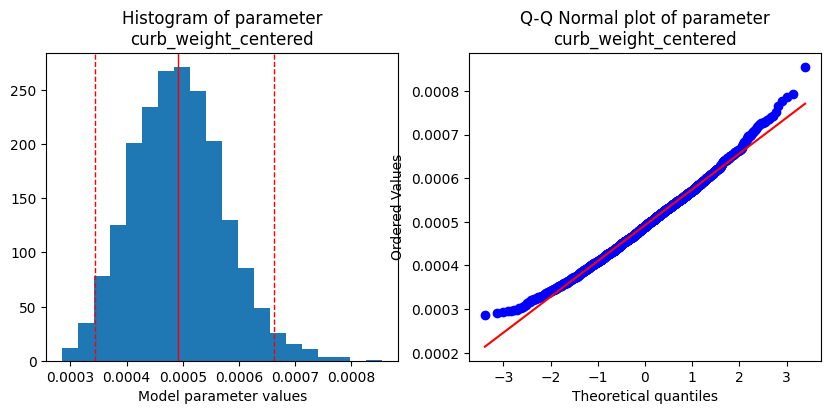

Parameter = engine_size_centered
Mean = 0.006929429706564377
Upper confidence interval = 0.009678846583433511
Lower confidence interval = 0.0038097790044565737


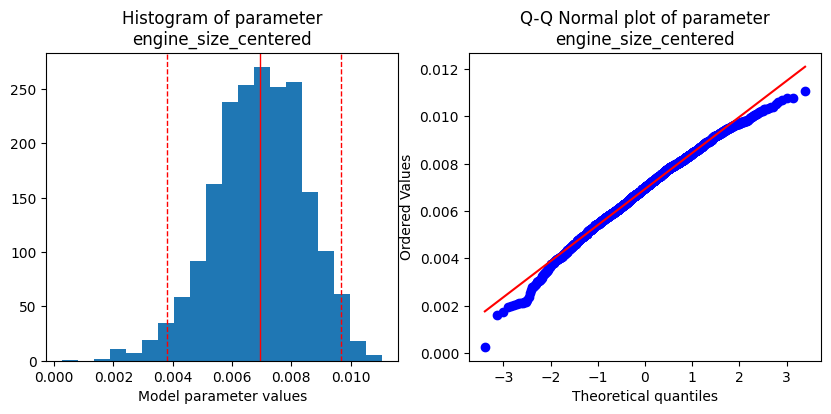

Parameter = curb_weight_centered:engine_size_centered
Mean = -2.7113092017090996e-06
Upper confidence interval = -1.0326794412971552e-06
Lower confidence interval = -4.164920902385882e-06


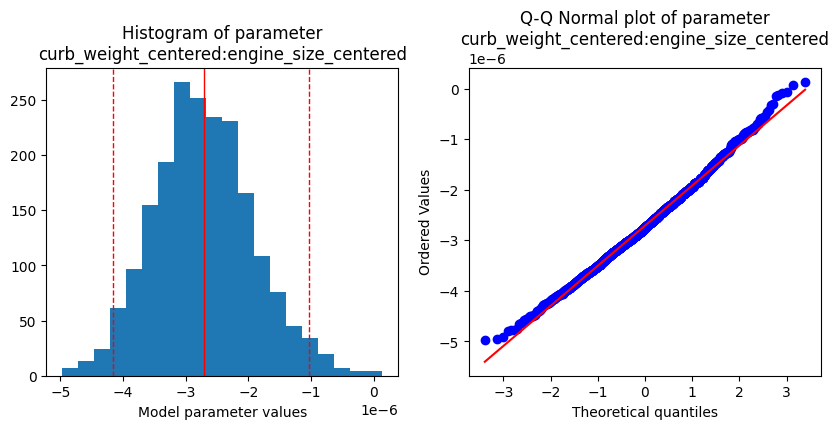

In [15]:
## Prepare the dataset
auto_price = pd.read_csv('/content/AutoPricesClean.csv')
auto_price['log_price'] = np.log(auto_price.loc[:,'price'])
for col,new_col in zip(['curb_weight','engine_size'],['curb_weight_centered','engine_size_centered']):
    auto_price[new_col] = auto_price.loc[:,col] - np.mean(auto_price.loc[:,col])

np.random.seed(2244)

## Perform 2000 bootstrap realizations using the provided formula
# The model has 4 parameters: intercept, curb_weight_centered, engine_size_centered, and their interaction
param_boots_auto = resample_regression(auto_price, n_boots=2000, n_params=4, formula='log_price ~ curb_weight_centered*engine_size_centered')

## Plot the bootstrap parameter distributions
# Intercept
plot_boot_params(param_boots_auto[:, 0], parameter='intercept')

# Curb weight centered
plot_boot_params(param_boots_auto[:, 1], parameter='curb_weight_centered')

# Engine size centered
plot_boot_params(param_boots_auto[:, 2], parameter='engine_size_centered')

# Interaction term
plot_boot_params(param_boots_auto[:, 3], parameter='curb_weight_centered:engine_size_centered')


> Now answer the following questions:     
> 1. Are the bootstrap distributions of all the variables Normally distributed or is the noticeable skew?  If skew is present, describe the skew for each parameter.    
> 2. Examine the 95% confidence intervals for each of the model parameters. Based on these CIs are all the parameters significant and if not, which parameters are not significant and why?     

> **Answers:**

> 1. The bootstrap distributions for most of the parameters, including the intercept, curb_weight_centered, and engine_size_centered, appear approximately Normally distributed, with only slight skew in the curb_weight_centered distribution, which shows a slight right skew. However, the interaction term (curb_weight_centered) shows more noticeable skew to the left.

> 2. Based on the 95% confidence intervals:
>  - The intercept, curb_weight_centered, and engine_size_centered parameters are significant as their confidence intervals do not include zero.
>  - The interaction term (curb_weight_centered) is not significant because its confidence interval includes zero (ranging from -4.16e-06 to -1.03e-06). Therefore, we cannot confidently say that this interaction effect has a meaningful impact on the model.







> **Exercise 21-2:** In the foregoing exercise, you have identified which regression model parameters are significant. Now, repeat the analysis you performed in Exercise 21-1, but using a model formula including only the significant parameters.  

Parameter = intercept
Mean = 9.350261750187471
Upper confidence interval = 9.37987888527013
Lower confidence interval = 9.321686822045343


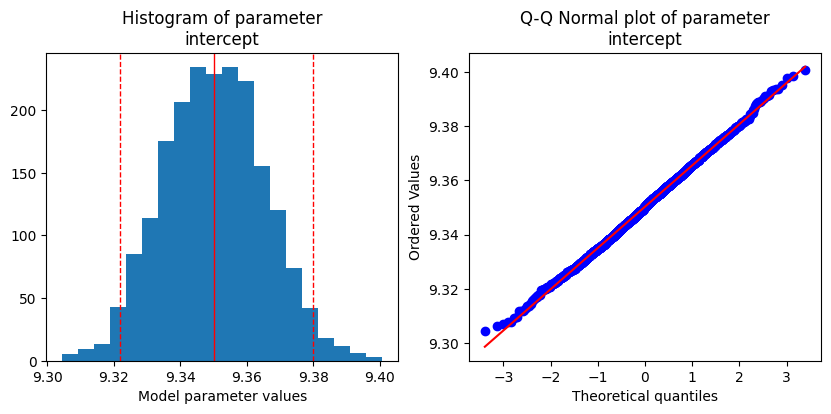

Parameter = curb_weight_centered
Mean = 0.0006008307147651867
Upper confidence interval = 0.0007572336735592737
Lower confidence interval = 0.00045578345481339807


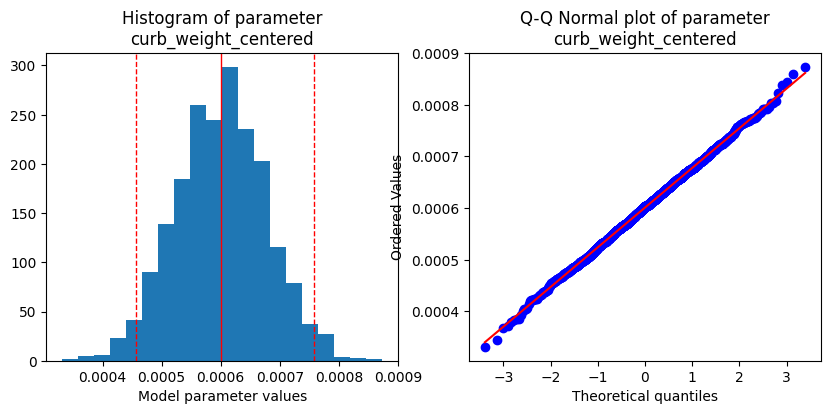

Parameter = engine_size_centered
Mean = 0.0040060038970404005
Upper confidence interval = 0.006622341610174329
Lower confidence interval = 0.0018021237087623495


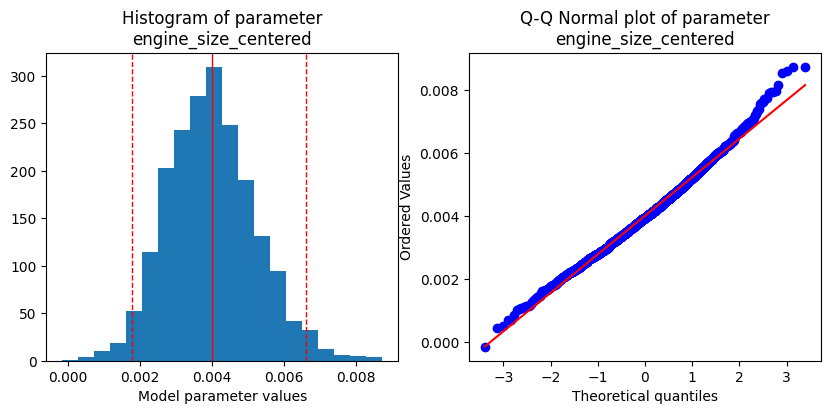

In [18]:
np.random.seed(2244)

## Use the significant parameters for bootstrap resampling with n_params set to 3
param_boots_significant = resample_regression(auto_price, n_boots=2000, n_params=3, formula='log_price ~ curb_weight_centered + engine_size_centered')

## Plot the bootstrap parameter distributions for the significant parameters
plot_boot_params(param_boots_significant[:,0], parameter='intercept')
plot_boot_params(param_boots_significant[:,1], parameter='curb_weight_centered')
plot_boot_params(param_boots_significant[:,2], parameter='engine_size_centered')


> Answer the following questions:    
> 1. Are all the parameters of your model significant now and why?    
> 2. Are the bootstrap distributions of the parameters reasonably Normal and why?    

> **Answers:**

> 1. Yes, all the parameters of the model are now significant. This conclusion is based on the 95% confidence intervals computed for each parameter, which do not include zero. Since the confidence intervals for the intercept, curb_weight_centered, and engine_size_centered parameters do not overlap zero, it means there is enough statistical evidence that these parameters are significantly contributing to the model

> 2. Yes, the bootstrap distributions of the parameters are reasonably Normal. This conclusion is supported by both the histograms and Q-Q plots, which show a near-symmetric shape for the distributions and close alignment of the quantiles with the theoretical normal line, respectively. The Q-Q plots indicate that the majority of the data points follow the Normal distribution, with minor deviations at the tails


#### Copyright 2017, 2018, 2020, 2022, 2023, 2024 Stephen F Elston. All rights reserved.